# Imports

In [ ]:
import torch
import torchvision
import numpy as np
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, Subset

# Model Architecture

In [ ]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x


def ConvMixer(dim, depth, kernel_size=5, patch_size=2, n_classes=10):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )

# Data Preprocessing

In [ ]:
cifar10_mean = (0.4914, 0.4822, 0.4465)
cifar10_std = (0.2471, 0.2435, 0.2616)

train_transform = transforms.Compose([
    transforms.RandomResizedCrop(32, scale=(0.75, 1.0), ratio=(1.0, 1.0)),
    transforms.RandomHorizontalFlip(p=0.5),
    transforms.RandAugment(num_ops=1, magnitude=8),
    transforms.ColorJitter(0.1, 0.1, 0.1),
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std),
    transforms.RandomErasing(p=0.25)
])

test_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(cifar10_mean, cifar10_std)
])
full_train_dataset = torchvision.datasets.CIFAR10(root='./data', train=True, download=True, transform=train_transform)
test_dataset = torchvision.datasets.CIFAR10(root='./data', train=False, download=True, transform=test_transform)

train_dataset = Subset(full_train_dataset, list(range(0, 45000)))
val_dataset = Subset(full_train_dataset, list(range(45000, 50000)))

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=2)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False, num_workers=2)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False, num_workers=2)

100%|██████████| 170498071/170498071 [00:08<00:00, 20756055.82it/s]


Extracting ./data/cifar-10-python.tar.gz to ./data
Files already downloaded and verified


In [14]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

num_params = count_parameters(model)
print(f"Number of parameters: {num_params}")

Number of parameters: 594186
Number of parameters: 594186


# Kernel size = 5, and lr_max = 0.001

In [ ]:
model = ConvMixer(256, 8, patch_size=2, kernel_size=5, n_classes=10)
model = nn.DataParallel(model).cuda()
lr_max = 0.001
num_epochs = 50
lr_schedule = lambda t: np.interp([t], [0, num_epochs*2//5, num_epochs*4//5, num_epochs],
                                  [0, lr_max, lr_max/20.0, 0])[0]
opt = optim.AdamW(model.parameters(), lr=lr_max, weight_decay=0.00001)
criterion = nn.CrossEntropyLoss()
# helps to speed up training
scaler = torch.cuda.amp.GradScaler()


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_acc, n = 0, 0, 0
    model.train()
    for i, (X, y) in enumerate(train_loader):
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(train_loader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)

    train_loss /= n
    train_acc = 100. * train_acc / n
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_acc, val_loss, m = 0, 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(val_loader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
                loss = criterion(output, y)
            val_loss += loss.item() * y.size(0)
            val_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    val_loss /= m
    val_acc = 100. * val_acc / m
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)
    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

# Test the model
test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)  # Sum the loss
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= total  # Normalize by the total number of samples
test_acc = 100. * correct / total  # Convert to percentage

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


Epoch [1/50], Train Loss: 1.9596, Train Acc: 28.01%, Val Loss: 1.5960, Val Acc: 41.12%
Epoch [2/50], Train Loss: 1.5006, Train Acc: 46.01%, Val Loss: 1.3401, Val Acc: 52.00%
Epoch [3/50], Train Loss: 1.2883, Train Acc: 53.91%, Val Loss: 1.1518, Val Acc: 58.12%
Epoch [4/50], Train Loss: 1.1386, Train Acc: 60.01%, Val Loss: 1.0499, Val Acc: 62.62%
Epoch [5/50], Train Loss: 1.0010, Train Acc: 64.93%, Val Loss: 0.9207, Val Acc: 67.90%
Epoch [6/50], Train Loss: 0.9012, Train Acc: 68.33%, Val Loss: 0.8286, Val Acc: 70.96%
Epoch [7/50], Train Loss: 0.8247, Train Acc: 71.43%, Val Loss: 0.7725, Val Acc: 73.58%
Epoch [8/50], Train Loss: 0.7645, Train Acc: 73.56%, Val Loss: 0.7108, Val Acc: 75.28%
Epoch [9/50], Train Loss: 0.7190, Train Acc: 75.30%, Val Loss: 0.6795, Val Acc: 76.18%
Epoch [10/50], Train Loss: 0.6797, Train Acc: 76.35%, Val Loss: 0.6735, Val Acc: 76.50%
Epoch [11/50], Train Loss: 0.6426, Train Acc: 77.48%, Val Loss: 0.6453, Val Acc: 77.18%
Epoch [12/50], Train Loss: 0.6139, Train 

NameError: name 'plt' is not defined

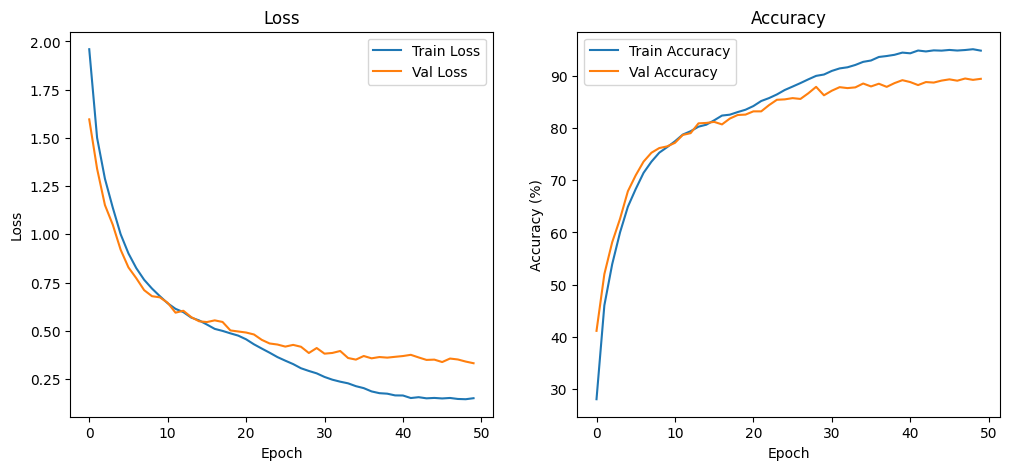

Test Loss: 0.2634, Test Accuracy: 91.95%


In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()

plt.show()

test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)  # Sum the loss
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= total  # Normalize by the total number of samples
test_acc = 100. * correct / total  # Convert to percentage

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


# Kernel size = 3, and lr_max = 0.0015

In [ ]:
model = ConvMixer(256, 8, patch_size=2, kernel_size=3, n_classes=10)
model = nn.DataParallel(model).cuda()

lr_max = 0.0015
num_epochs = 45


lr_schedule = lambda t: np.interp([t], [0, num_epochs*2//5, num_epochs*4//5, num_epochs],
                                  [0, lr_max, lr_max/20.0, 0])[0]

opt = optim.AdamW(model.parameters(), lr=lr_max, weight_decay=0.00001)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()


In [ ]:
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
for epoch in range(num_epochs):
    train_loss, train_acc, n = 0, 0, 0
    model.train()
    for i, (X, y) in enumerate(train_loader):
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(train_loader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)

    train_loss /= n
    train_acc = 100. * train_acc / n
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_acc, val_loss, m = 0, 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(val_loader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
                loss = criterion(output, y)
            val_loss += loss.item() * y.size(0)
            val_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    val_loss /= m
    val_acc = 100. * val_acc / m
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


Epoch [1/45], Train Loss: 1.8989, Train Acc: 29.79%, Val Loss: 1.5511, Val Acc: 42.62%
Epoch [2/45], Train Loss: 1.4030, Train Acc: 49.63%, Val Loss: 1.2470, Val Acc: 55.44%
Epoch [3/45], Train Loss: 1.1813, Train Acc: 58.10%, Val Loss: 1.0430, Val Acc: 63.12%
Epoch [4/45], Train Loss: 1.0325, Train Acc: 63.81%, Val Loss: 0.9211, Val Acc: 67.04%
Epoch [5/45], Train Loss: 0.9193, Train Acc: 67.94%, Val Loss: 0.8373, Val Acc: 70.84%
Epoch [6/45], Train Loss: 0.8291, Train Acc: 71.32%, Val Loss: 0.7547, Val Acc: 73.40%
Epoch [7/45], Train Loss: 0.7601, Train Acc: 73.75%, Val Loss: 0.7261, Val Acc: 74.64%
Epoch [8/45], Train Loss: 0.7146, Train Acc: 75.30%, Val Loss: 0.6742, Val Acc: 76.58%
Epoch [9/45], Train Loss: 0.6794, Train Acc: 76.62%, Val Loss: 0.6615, Val Acc: 77.12%
Epoch [10/45], Train Loss: 0.6522, Train Acc: 77.54%, Val Loss: 0.6219, Val Acc: 79.12%
Epoch [11/45], Train Loss: 0.6295, Train Acc: 78.22%, Val Loss: 0.6225, Val Acc: 78.88%
Epoch [12/45], Train Loss: 0.6035, Train 

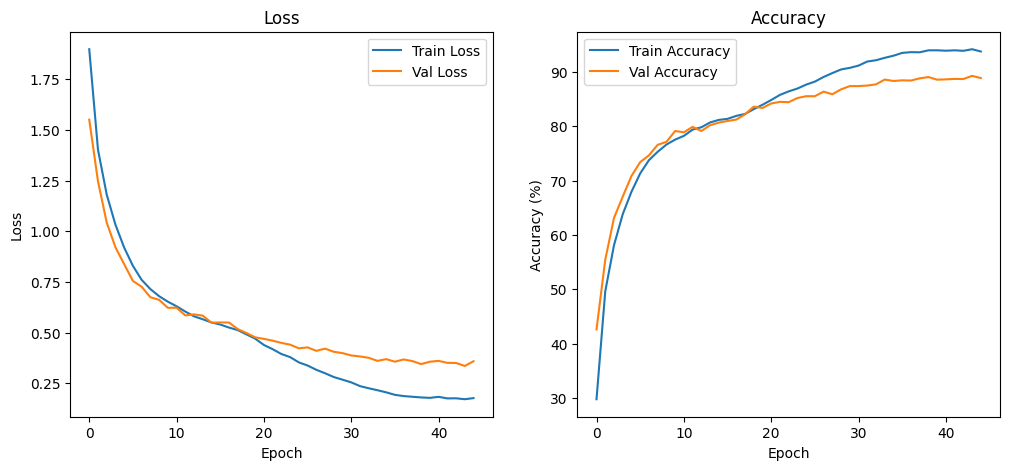

Test Loss: 0.2744, Test Accuracy: 91.56%


In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= total
test_acc = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


# Add dropout

In [11]:
class Residual(nn.Module):
    def __init__(self, fn):
        super().__init__()
        self.fn = fn

    def forward(self, x):
        return self.fn(x) + x

def ConvMixer(dim, depth, kernel_size=5, patch_size=2, n_classes=10, dropout_rate=0.3):
    return nn.Sequential(
        nn.Conv2d(3, dim, kernel_size=patch_size, stride=patch_size),
        nn.GELU(),
        nn.BatchNorm2d(dim),
        *[nn.Sequential(
                Residual(nn.Sequential(
                    nn.Conv2d(dim, dim, kernel_size, groups=dim, padding="same"),
                    nn.GELU(),
                    nn.BatchNorm2d(dim)
                )),
                nn.Conv2d(dim, dim, kernel_size=1),
                nn.GELU(),
                nn.BatchNorm2d(dim),
                nn.Dropout(dropout_rate)
        ) for i in range(depth)],
        nn.AdaptiveAvgPool2d((1,1)),
        nn.Flatten(),
        nn.Linear(dim, n_classes)
    )



In [ ]:
model = ConvMixer(256, 8, patch_size=2, kernel_size=3, n_classes=10, dropout_rate=0.15)
model = nn.DataParallel(model).cuda()
lr_max = 0.002
num_epochs = 50
lr_schedule = lambda t: np.interp([t], [0, num_epochs*2//5, num_epochs*4//5, num_epochs],
                                  [0, lr_max, lr_max/20.0, 0])[0]
opt = optim.AdamW(model.parameters(), lr=lr_max, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
scaler = torch.cuda.amp.GradScaler()
train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0  # Initialize best validation accuracy
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    train_loss, train_acc, n = 0, 0, 0
    model.train()
    for i, (X, y) in enumerate(train_loader):
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(train_loader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)

    train_loss /= n
    train_acc = 100. * train_acc / n
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_acc, val_loss, m = 0, 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(val_loader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
                loss = criterion(output, y)
            val_loss += loss.item() * y.size(0)
            val_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    val_loss /= m
    val_acc = 100. * val_acc / m
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')


    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)


Files already downloaded and verified
Files already downloaded and verified
Epoch [1/50], Train Loss: 1.9274, Train Acc: 28.37%, Val Loss: 1.7256, Val Acc: 35.52%
Epoch [2/50], Train Loss: 1.4794, Train Acc: 46.46%, Val Loss: 1.4291, Val Acc: 46.32%
Epoch [3/50], Train Loss: 1.2668, Train Acc: 54.73%, Val Loss: 1.1615, Val Acc: 57.80%
Epoch [4/50], Train Loss: 1.1166, Train Acc: 60.37%, Val Loss: 1.0369, Val Acc: 62.58%
Epoch [5/50], Train Loss: 0.9929, Train Acc: 65.05%, Val Loss: 0.9028, Val Acc: 67.54%
Epoch [6/50], Train Loss: 0.9068, Train Acc: 68.45%, Val Loss: 0.8661, Val Acc: 69.12%
Epoch [7/50], Train Loss: 0.8397, Train Acc: 71.03%, Val Loss: 0.8144, Val Acc: 71.36%
Epoch [8/50], Train Loss: 0.7957, Train Acc: 72.32%, Val Loss: 0.7427, Val Acc: 74.12%
Epoch [9/50], Train Loss: 0.7432, Train Acc: 74.38%, Val Loss: 0.6786, Val Acc: 76.60%
Epoch [10/50], Train Loss: 0.7267, Train Acc: 74.66%, Val Loss: 0.6530, Val Acc: 76.86%
Epoch [11/50], Train Loss: 0.6954, Train Acc: 75.84%,

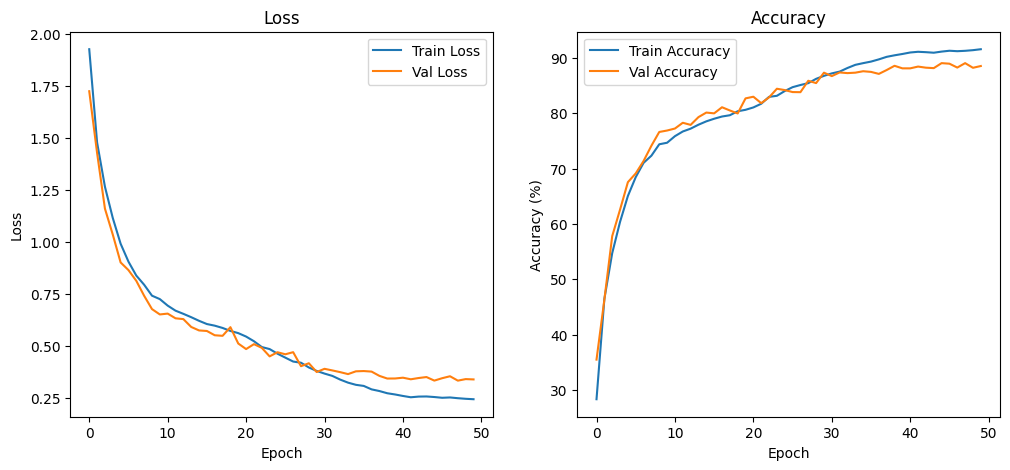

Test Loss: 0.2732, Test Accuracy: 90.91%


In [ ]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

test_loss, correct, total = 0, 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= total
test_acc = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')


# Second version Dropout

In [12]:
model = ConvMixer(256, 8, patch_size=2, kernel_size=5, n_classes=10, dropout_rate=0.1)
model = nn.DataParallel(model).cuda()

lr_max = 0.001
num_epochs = 60

lr_schedule = lambda t: np.interp([t], [0, num_epochs*2//5, num_epochs*4//5, num_epochs],
                                  [0, lr_max, lr_max/20.0, 0])[0]

opt = optim.AdamW(model.parameters(), lr=lr_max, weight_decay=0.0001)
criterion = nn.CrossEntropyLoss()
# helps to speed up training
scaler = torch.cuda.amp.GradScaler()

train_losses = []
val_losses = []
train_accuracies = []
val_accuracies = []
best_val_acc = 0.0  # Initialize best validation accuracy
best_model_path = 'best_model.pth'

for epoch in range(num_epochs):
    train_loss, train_acc, n = 0, 0, 0
    model.train()
    for i, (X, y) in enumerate(train_loader):
        X, y = X.cuda(), y.cuda()

        lr = lr_schedule(epoch + (i + 1)/len(train_loader))
        opt.param_groups[0].update(lr=lr)

        opt.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(X)
            loss = criterion(output, y)

        scaler.scale(loss).backward()
        scaler.step(opt)
        scaler.update()

        train_loss += loss.item() * y.size(0)
        train_acc += (output.max(1)[1] == y).sum().item()
        n += y.size(0)

    train_loss /= n
    train_acc = 100. * train_acc / n
    train_losses.append(train_loss)
    train_accuracies.append(train_acc)

    model.eval()
    val_acc, val_loss, m = 0, 0, 0
    with torch.no_grad():
        for i, (X, y) in enumerate(val_loader):
            X, y = X.cuda(), y.cuda()
            with torch.cuda.amp.autocast():
                output = model(X)
                loss = criterion(output, y)
            val_loss += loss.item() * y.size(0)
            val_acc += (output.max(1)[1] == y).sum().item()
            m += y.size(0)

    val_loss /= m
    val_acc = 100. * val_acc / m
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    print(f'Epoch [{epoch+1}/{num_epochs}], Train Loss: {train_loss:.4f}, Train Acc: {train_acc:.2f}%, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.2f}%')

# saving the best model based on its performance on Validation set
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        torch.save(model.state_dict(), best_model_path)

Epoch [1/60], Train Loss: 1.9992, Train Acc: 25.31%, Val Loss: 1.7272, Val Acc: 34.98%
Epoch [2/60], Train Loss: 1.5544, Train Acc: 43.38%, Val Loss: 1.5136, Val Acc: 44.72%
Epoch [3/60], Train Loss: 1.3646, Train Acc: 50.96%, Val Loss: 1.3700, Val Acc: 49.10%
Epoch [4/60], Train Loss: 1.2179, Train Acc: 56.70%, Val Loss: 1.1270, Val Acc: 59.34%
Epoch [5/60], Train Loss: 1.1008, Train Acc: 60.98%, Val Loss: 1.0000, Val Acc: 65.34%
Epoch [6/60], Train Loss: 1.0028, Train Acc: 64.80%, Val Loss: 0.9152, Val Acc: 67.76%
Epoch [7/60], Train Loss: 0.9138, Train Acc: 68.14%, Val Loss: 0.8504, Val Acc: 70.40%
Epoch [8/60], Train Loss: 0.8485, Train Acc: 70.14%, Val Loss: 0.7677, Val Acc: 73.04%
Epoch [9/60], Train Loss: 0.7970, Train Acc: 72.25%, Val Loss: 0.7257, Val Acc: 74.44%
Epoch [10/60], Train Loss: 0.7524, Train Acc: 73.88%, Val Loss: 0.7004, Val Acc: 75.54%
Epoch [11/60], Train Loss: 0.7154, Train Acc: 75.19%, Val Loss: 0.6673, Val Acc: 76.94%
Epoch [12/60], Train Loss: 0.6812, Train 

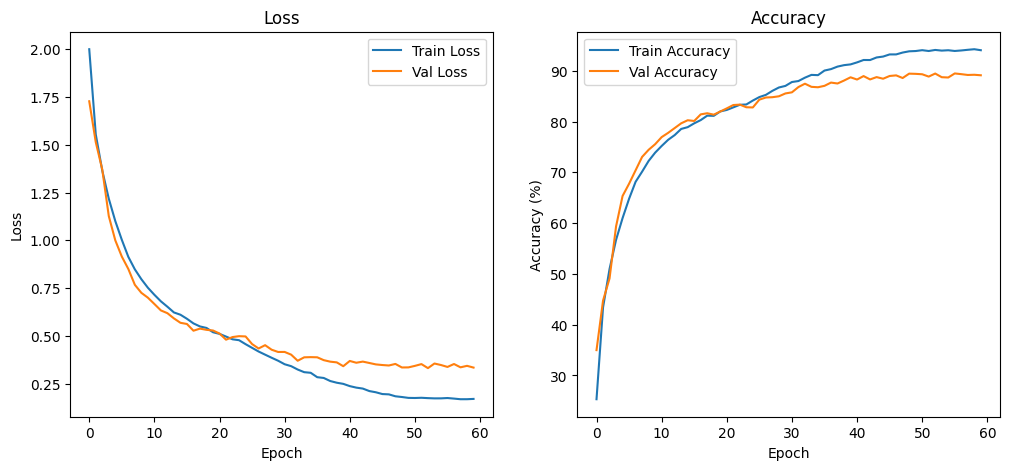

Test Loss: 0.2643, Test Accuracy: 92.05%


In [15]:
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Val Loss')
plt.title('Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(train_accuracies, label='Train Accuracy')
plt.plot(val_accuracies, label='Val Accuracy')
plt.title('Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy (%)')
plt.legend()
plt.show()

test_loss, correct, total = 0, 0, 0
model.load_state_dict(torch.load('/content/best_model.pth'))
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to('cuda'), labels.to('cuda')
        outputs = model(images)
        loss = criterion(outputs, labels)
        test_loss += loss.item() * labels.size(0)
        _, predicted = outputs.max(1)
        total += labels.size(0)
        correct += predicted.eq(labels).sum().item()

test_loss /= total
test_acc = 100. * correct / total

print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.2f}%')
